In [2]:
import yaml
import os
import tqdm
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pytorch_lightning import Trainer
import cv2
from model import LitSegment
import albumentations as A
import json
from data import DataWrapper
from utility import labelme2mask, mask2labelme, get_height_of_the_contour
import shapely
from shapely.geometry import Polygon



torch.set_float32_matmul_precision('high')


# lit = LitSegment.load_from_checkpoint(os.path.join(config['training']['save_weights_dir'], config['training']['wandb_run_name'], checkpoint_name))
# lit.test_results_folder = output_folder
# lit.conf_prediction = config['prediction']

# trainer = Trainer(
#                 accelerator="cuda",
#                 devices=[0],
#                 )

# trainer.test(lit, dm)



/mnt/data/psemchyshyn/conda/miniconda/envs/top-detection/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
image_src = "/mnt/data/psemchyshyn/top-detection/mlc_training_data/images"
label_src = "/mnt/data/psemchyshyn/top-detection/mlc_training_data/ground_truth_files"
label_predicted_src = "/mnt/data/psemchyshyn/top-detection/val/temp_val_results"
image_w = 512
image_h = 512
names = os.listdir(label_predicted_src)
names = list(map(lambda x: x.split('.')[0], names))

In [16]:
name = names[4]
name

'ahapxeqibq'

In [17]:
image_path = os.path.join(image_src, f"{name}.png")
image = Image.open(image_path)

with open(os.path.join(label_src, f"{name}.json"), 'r') as f:
    annotation_gt = json.load(f)

with open(os.path.join(label_predicted_src, f"{name}.json"), 'r') as f:
    annotation_pred = json.load(f)


mask_roof_gt, mask_height_gt = labelme2mask(annotation_gt, image.width, image.height)
mask_roof_pred, mask_height_pred = labelme2mask(annotation_pred, image.width, image.height)
image = np.asarray(image)

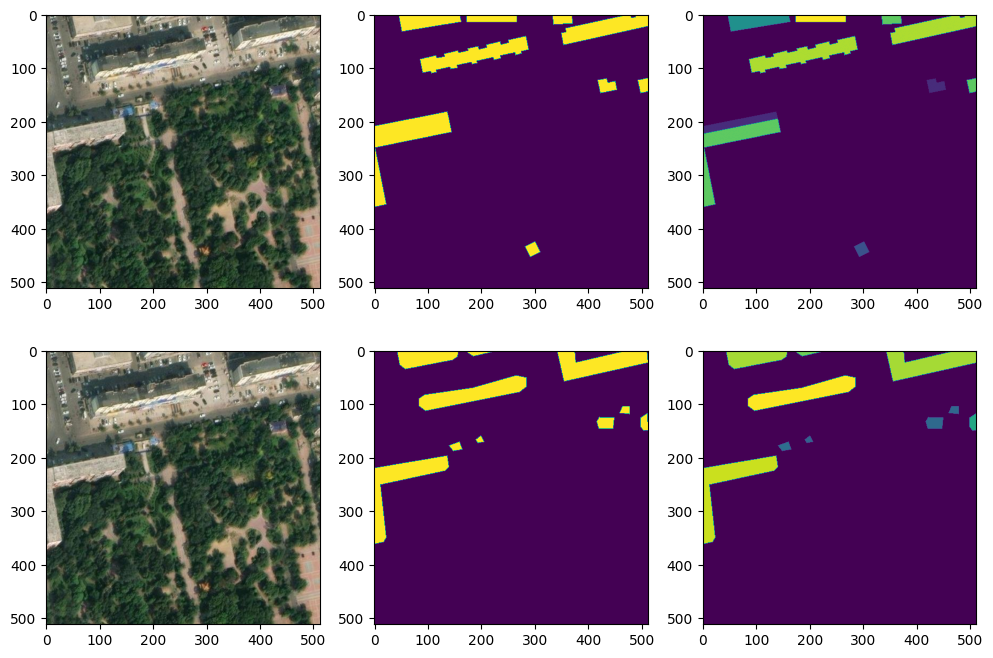

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
ax1.imshow(image)
ax2.imshow(mask_roof_gt)
ax3.imshow(mask_height_gt)
ax4.imshow(image)
ax5.imshow(mask_roof_pred)
ax6.imshow(mask_height_pred)
plt.show()

In [6]:
augs = A.Compose([
    A.Resize(512, 512),
    A.RandomSizedCrop(min_max_height=(350, 512), w2h_ratio=1, height=512, width=512, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),
    A.RandomGamma(p=0.8),
    ], additional_targets={'mask_roof': 'mask', 'mask_height': 'mask'})

In [7]:
transformed = augs(image=image, mask_roof=mask_roof_gt, mask_height=mask_height_gt)
aug_image = transformed["image"]
aug_mask_roof = transformed["mask_roof"]
aug_mask_height = transformed["mask_height"]

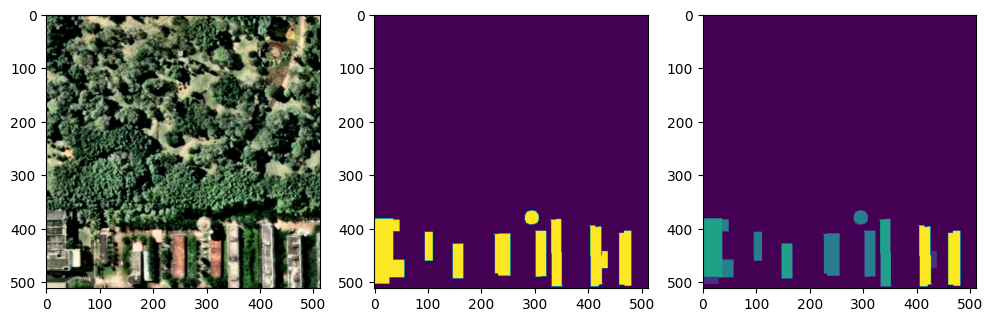

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.imshow(aug_image)
ax2.imshow(aug_mask_roof)
ax3.imshow(aug_mask_height)
plt.show()


In [22]:
def get_file_stat(name, annotation):
    result = []

    for shape in annotation['shapes']:
        polygon = shape['points']
        polygon_obj = Polygon(polygon)
        building = {
            'id':name,
            'area': polygon_obj.area,
            'total_vertices': len(polygon),
            'total_ext_vertices': len(list(polygon_obj.exterior.coords)[:-1]),
            'height': shape['group_id']
        }

        result.append(building)

    return result

def get_all_df(names, labels_path):
    total_buildings = []
    for name in tqdm.tqdm(names):
        annotation_path = os.path.join(labels_path, f"{name}.json")
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)
        buildings = get_file_stat(name, annotation)
        total_buildings.extend(buildings)
    return pd.DataFrame(total_buildings)

In [23]:
df_gt = get_all_df(names, label_src)
df_gt

100%|██████████| 500/500 [00:00<00:00, 1671.84it/s]


,id,area,total_vertices,total_ext_vertices,height
0,tubgdxzwoo,331.0,36,36,9
1,tubgdxzwoo,180.0,4,4,3
2,tubgdxzwoo,1476.5,8,8,21
3,tubgdxzwoo,1520.0,8,8,21
4,tubgdxzwoo,1331.0,8,8,21
...,...,...,...,...,...
14573,mkfoyswojw,2013.5,5,5,48
14574,mkfoyswojw,3433.5,4,4,6
14575,mkfoyswojw,2296.0,6,6,9
14576,mkfoyswojw,3086.5,5,5,9


In [24]:
df_pred = get_all_df(names, label_predicted_src)
df_pred

100%|██████████| 500/500 [00:00<00:00, 2927.41it/s]


,id,area,total_vertices,total_ext_vertices,height
0,tubgdxzwoo,4189.0,10,10,8.992112
1,tubgdxzwoo,282.5,4,4,4.652051
2,tubgdxzwoo,416.0,5,5,4.198421
3,tubgdxzwoo,592.0,6,6,4.791905
4,tubgdxzwoo,1274.0,8,8,3.769462
...,...,...,...,...,...
7540,mkfoyswojw,45289.0,8,8,13.062425
7541,mkfoyswojw,65340.5,10,10,14.124011
7542,mkfoyswojw,8264.5,5,5,14.062901
7543,mkfoyswojw,6408.5,12,12,18.492008


In [25]:
df_gt['id'].unique().shape, df_pred['id'].unique().shape

((500,), (499,))

In [26]:
df_pred['type'] = 'pred'
df_gt['type'] = 'gt'

df = pd.concat([df_pred, df_gt])
df

,id,area,total_vertices,total_ext_vertices,height,type
0,tubgdxzwoo,4189.0,10,10,8.992112,pred
1,tubgdxzwoo,282.5,4,4,4.652051,pred
2,tubgdxzwoo,416.0,5,5,4.198421,pred
3,tubgdxzwoo,592.0,6,6,4.791905,pred
4,tubgdxzwoo,1274.0,8,8,3.769462,pred
...,...,...,...,...,...,...
14573,mkfoyswojw,2013.5,5,5,48.000000,gt
14574,mkfoyswojw,3433.5,4,4,6.000000,gt
14575,mkfoyswojw,2296.0,6,6,9.000000,gt
14576,mkfoyswojw,3086.5,5,5,9.000000,gt


In [27]:
df[df['type'] == 'gt'].describe()

,area,total_vertices,total_ext_vertices,height
count,14578.000000,14578.000000,14578.000000,14578.000000
mean,1909.165599,5.568322,5.494101,15.058170
std,4091.008095,3.917273,3.936764,18.153898
min,1.500000,3.000000,3.000000,3.000000
25%,415.000000,4.000000,4.000000,6.000000
50%,930.000000,4.000000,4.000000,9.000000
75%,2333.375000,5.000000,5.000000,18.000000
max,153887.500000,77.000000,77.000000,245.000000


In [28]:
df[df['type'] == 'pred'].describe()

,area,total_vertices,total_ext_vertices,height
count,7545.000000,7545.000000,7545.000000,7545.000000
mean,3836.579788,7.681776,7.681776,15.635084
std,7880.259820,5.383773,5.383773,15.199274
min,0.500000,3.000000,3.000000,0.958583
25%,732.000000,5.000000,5.000000,8.141983
50%,2019.000000,7.000000,7.000000,11.204220
75%,4049.000000,8.000000,8.000000,16.694481
max,234176.500000,140.000000,140.000000,110.294594


In [18]:
import torch
import torch.nn.functional as F

# Create a tensor representing an image with shape [batch_size, channels, height, width]
image_tensor = torch.randn(1, 3, 100, 100)  # Example tensor with shape [1, 3, 100, 100]

# Resize the image tensor to a new size (e.g., 64x64) using bilinear interpolation
resized_image = F.interpolate(image_tensor, size=(64, 64), mode='bilinear', align_corners=False)

resized_image.shape

torch.Size([1, 3, 64, 64])

In [19]:
import torch
import cv2
from skimage import measure

# Assuming your binary mask is a torch tensor
binary_mask = torch.tensor([[[0, 1, 1, 0, 0],
                            [0, 1, 0, 0, 0],
                            [1, 0, 1, 0, 1],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0]],
                            [[0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 1, 1, 0, 0]]])

# Convert the tensor to a numpy array
binary_mask_np = np.uint8(binary_mask.numpy())

res = measure.label(binary_mask_np)
# Print the connected components
print(res)

[[[0 1 1 0 0]
  [0 1 0 0 0]
  [1 0 1 0 2]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 3 3 0 0]]]


In [20]:
torch.flatten(binary_mask.float()).mode()[0]

tensor(0.)

In [21]:
import skimage

y_hat_roof_element = np.array([[0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 0],
                                [1, 0, 1, 0, 1],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 1]])


mask_height_element = torch.tensor([[0, 10, 10, 10, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [55, 0, 0, 0, 0],
                            [0, 0, 0, 5, 5]])


In [22]:
target = torch.zeros(y_hat_roof_element.shape)
connected_regions = skimage.measure.label(y_hat_roof_element)
max_label = connected_regions.max()
connected_regions = torch.from_numpy(connected_regions)
for i in range(1, max_label + 1):
    area_of_interest = mask_height_element.where(connected_regions == i, -1).flatten()
    area_of_interest = area_of_interest[area_of_interest > 0]
    if area_of_interest.nelement() != 0:
        target[connected_regions == i] = area_of_interest[area_of_interest >= 0].mode()[0]
    else:
        target[connected_regions == i] = 0


target

tensor([[ 0., 10., 10.,  0.,  0.],
        [ 0., 10.,  0.,  0.,  0.],
        [10.,  0., 10.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  5.]])

In [1]:
from segmentation.model import LitSegment
import yaml
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import albumentations as A
import json
from data import DataWrapper
from utility import labelme2mask, mask2labelme, get_height_of_the_contour
import shapely
from shapely.geometry import Polygon

torch.hub.set_dir('/mnt/data/psemchyshyn/top-detection/cache')



/mnt/data/psemchyshyn/conda/miniconda/envs/top-detection/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_folder = 'temp'
mode='val'
os.makedirs(output_folder, exist_ok=True)

config_path = 'segmentation/config.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dm = DataWrapper(config, test=mode)

lit = LitSegment.load_from_checkpoint(os.path.join(config['training']['save_weights_dir'], config['training']['wandb_run_name'], 'model-epoch=61.ckpt')).cuda()
lit.test_results_folder = output_folder
lit.conf_prediction = config['prediction']



In [1]:
import torch
from segmentation.model import LitSegment
lit = LitSegment.load_from_checkpoint('/mnt/data/psemchyshyn/top-detection/checkpoints/segmentator_mitb3_enc_train_no_augs_jaccard_loss_height9/last.ckpt', map_location=torch.device("cpu"))
lit


/mnt/data/psemchyshyn/conda/miniconda/envs/top-detection/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b3.pth" to /home/psemchyshyn/.cache/torch/hub/checkpoints/mit_b3.pth
100%|██████████| 170M/170M [01:09<00:00, 2.55MB/s] 


LitSegment(
  (model_roof): Unet(
    (encoder): MixVisionTransformerEncoder(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): OverlapPatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): OverlapPatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): OverlapPatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (block1): ModuleList(
        (0): Block(
          (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=T

In [2]:
lit.config

{'data': {'image_path': '/mnt/data/psemchyshyn/top-detection/mlc_training_data/images',
  'label_path': '/mnt/data/psemchyshyn/top-detection/mlc_training_data/ground_truth_files',
  'test_data_path': '/mnt/data/psemchyshyn/top-detection/mlc_test_images',
  'image_w': 512,
  'image_h': 512,
  'original_image_size': 512,
  'train_size': 0.8,
  'batch_size': 16,
  'train_augs': 'medium',
  'val_augs': 'none'},
 'model_roof': {'model_name': 'unet',
  'encoder_name': 'mit_b3',
  'channels': 3,
  'encoder_depth': 5,
  'encoder_weights': 'imagenet',
  'loss': 'jaccard'},
 'training': {'lr': 0.0001,
  'epochs': 20,
  'set_height_to': 9.0,
  'save_logs_dir': 'logs',
  'save_weights_dir': '/mnt/data/psemchyshyn/top-detection/checkpoints',
  'save_results_dir': 'test_results',
  'save_temp_val_results_dir': 'temp_val_results',
  'save_temp_train_results_dir': 'temp_train_results',
  'train_labels_dir': '/mnt/data/psemchyshyn/top-detection/train/labels',
  'val_labels_dir': '/mnt/data/psemchyshyn/

In [68]:
element = dm.val_dataset[0]

pred_mask = lit.predict(element, output_folder, lit.conf_prediction)

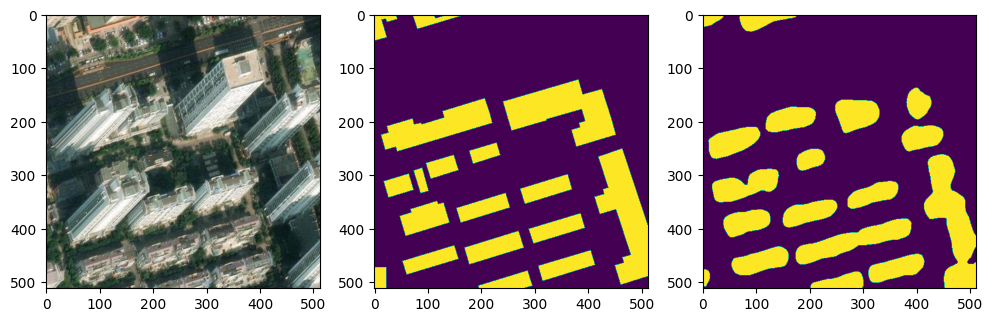

In [69]:
image = element['image'].permute(1, 2, 0).numpy()
mask = element['mask_roof'].squeeze(0).numpy()



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(pred_mask)
plt.show()


In [7]:
pred_mask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [47]:
import cv2
import numpy as np
from scipy.ndimage import label

# Step 1: Load the mask (Assuming mask is a binary image with ships represented by white pixels)
mask = np.uint8(pred_mask*255)

# Step 2: Determine the major axis orientation
def get_orientation(mask):
    moments = cv2.moments(mask)
    angle = 0.5 * np.arctan2(2 * moments['mu11'], moments['mu20'] - moments['mu02'])
    return np.rad2deg(angle)

angle = get_orientation(mask)

# Step 3: Create a thin rectangular structuring element aligned with the major axis
size = 15  # Length of the structuring element
thickness = 1  # Thickness of the structuring element
M = cv2.getRotationMatrix2D((size//2, thickness//2), angle, 1)
struct_element = cv2.warpAffine(np.ones((thickness, size), dtype=np.uint8), M, (size, thickness))

# Step 4: Apply erosion
eroded_mask = cv2.erode(mask,  np.ones((5, 5), np.uint8))

# Step 5: Apply watershed algorithm
# Find sure foreground area using distance transform
dist_transform = cv2.distanceTransform(eroded_mask, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 3, 255, cv2.THRESH_BINARY)

# Convert to uint8
sure_fg = np.uint8(sure_fg)

# Find unknown region
unknown = cv2.subtract(mask, sure_fg)

# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(mask_colored, markers)
mask_colored[markers == -1] = [255, 0, 0]  # Mark boundaries with red




In [78]:
def approximate_polygon(contour, epsilon=0.02):
    # Epsilon determines the precision of the approximation
    contour = cv2.approxPolyDP(contour, epsilon * cv2.arcLength(contour, True), True)
    
    # Convert the approximated polygon to have right angles
    # This can be achieved by custom logic to force right angles, which may involve
    # computing bounding boxes or fitting rectangles.
    # Here is a simple example for converting to bounding box (rectangles):
    rectangle = cv2.convexHull(contour)
    return rectangle

# Approximate contours to polygons with right angles
mask = np.uint8(pred_mask*255)
kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as needed
dilated = cv2.dilate(mask, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
polygons = [approximate_polygon(contour) for contour in contours]

sharp_mask = np.zeros_like(pred_mask)

# Draw the polygons
for polygon in polygons:
    cv2.drawContours(sharp_mask, [polygon], -1, (255), thickness=cv2.FILLED)




In [58]:
mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

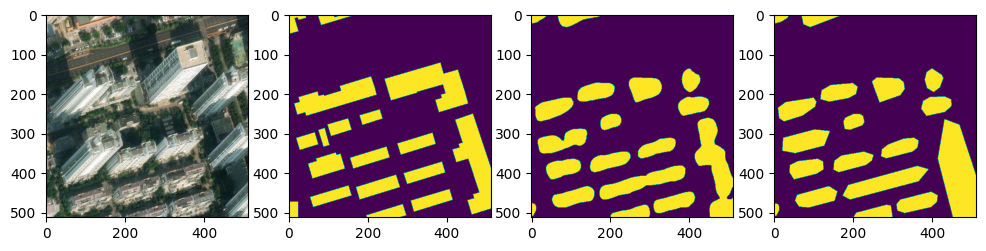

In [79]:
image = element['image'].permute(1, 2, 0).numpy()
mask = element['mask_roof'].squeeze(0).numpy()



fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 8))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(pred_mask)
ax4.imshow(sharp_mask)
plt.show()
